In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/chenyu/Desktop/GaussianProcess/GPTrelated')
saveResultsQ = False
import scipy
import tensorflow as tf
# %matplotlib qt
# %matplotlib
from scipy import optimize

failed to import parallelstuff


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="0" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [29]:
# free space from GPU device
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
def emittance(x):
#     ndim = 7
#     acquisition_delay = 0
#     dev_ids =  [str(x+1) for x in np.arange(ndim)]
#     mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
#     mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = [x], CNNoption=1) 
    print(x)
    mi.setX([x])
    temp = -mi.getState()[1][0][0]
    
    return temp

In [10]:
def run_simplex():
    
    max_iter = 500
    xtol=1e-7
    ftol = 1e-5
    objective_s = []
    quads = []
    test = [1919.8043413403848, 1.5271977112107802, 388933.6391666969, 
                    -652306.4409192496, -3750605.96540601, 119325.35862931717, 640381.8436611011]
    def store(x):
        objective_s.append(-emittance(x))      
        quads.append(x)
        clear_output(wait=True)
        f = plt.figure(figsize=(20,4))
        ax = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        ax.set_ylabel('Quads',fontsize=12)
        ax.set_xlabel('iteration',fontsize=12)
        ax.plot(quads)
        ax2.set_ylabel('Obj_state_s',fontsize=12)
        ax2.set_xlabel('iteration',fontsize=12)
        ax2.plot(objective_s,marker='.',linestyle='-')
        plt.show();
        
#     ndim = 7
#     acquisition_delay = 0
#     dev_ids =  [str(x+1) for x in np.arange(ndim)]
#     mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
#     mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = [x], CNNoption=1)
    
    output = optimize.fmin(emittance, test , maxiter=max_iter, callback = store, 
                           maxfun = max_iter,ftol=ftol,xtol=xtol,  initial_simplex=isim, disp=True,full_output=True)        
#     
    return quads,objective_s,output

In [20]:
test = [1919.8043413403848, 1.5271977112107802, 388933.6391666969, 
                -652306.4409192496, -3750605.96540601, 119325.35862931717, 640381.8436611011]
ndim = 7
acquisition_delay = 0
dev_ids =  [str(x+1) for x in np.arange(ndim)]
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = [test], CNNoption=1)

Model loaded


In [24]:
# hyperparameters determined using GPy for emittance from CNN
ndim = 7
gp_ls = np.array(np.ones(ndim)) * [0.485, 0.138, 0.634, 0.177, 0.976, 1.669, 1.230] * 700
gp_amp = 0.0587
gp_noise = 0.0587  # default = 0.001
gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP
gp = OGP(ndim, hyps,prmean=0)

In [25]:
isim =np.zeros((len(gp_ls) + 1, len(gp_ls)))
x = test
isim[0, :] = x
for i in range(len(x)):
    vertex = np.zeros(len(x))
    vertex[i] = gp_ls[i]
    isim[i + 1, :] = x + vertex  #vertex

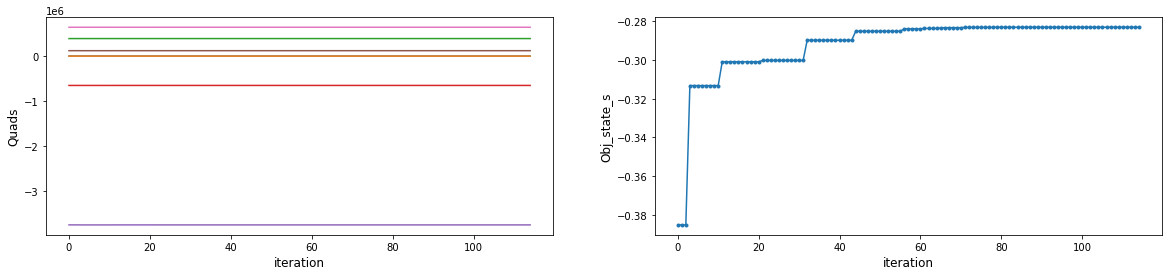

Optimization terminated successfully.
         Current function value: 0.283133
         Iterations: 116
         Function evaluations: 411


In [26]:
quads,objective_s,output = run_simplex()

In [27]:
temp = np.asarray(quads)
temp2 = np.asarray(objective_s)
temp2 = np.expand_dims(temp2, 1)
print(temp.shape)
print(temp2.shape)
temp3 = np.concatenate((temp, temp2), axis = 1)
np.save('HP-TL-Obj_1000e_UCB_2-0_Emit_300iter_oldWhiteNoise_01_simplex_140xWiderRange.npy',temp3)

(115, 7)
(115, 1)


In [23]:
temp3.shape

(73, 8)